# Reading NY Taxi Csv on EC2 Benchmark

## tl;dr

For reading large csv files with a small number of columns, a block size of 4 MB is a good choice on all AWS EC2 instance types.

## Experiment details

We ran a script that:

1. spins up an EC2 instance,
2. downloads the NY Yellow Taxi Trip dataset from January 2020,
3. reads it many times with pyarrow with different block sizes,
4. saves the results somewhere.

Below is a short, basic analysis of the output of the experiment.

We hope it will be useful :)

## Load data

In [25]:
import pandas as pd
import os
import json

ram = pd.DataFrame(
    [
        ["m5.large", 8, 2],
        ["m5.12xlarge", 192, 48],
        ["m5.16xlarge", 256, 64],
        ["m5.8xlarge", 128, 32],
        ["r5a.16xlarge", 512, 64],
        ["r5a.12xlarge", 384, 48],
        ["m5.4xlarge", 64, 16],
        ["r5a.8xlarge", 256, 32],
        ["r5a.24xlarge", 768, 96],
        ["r5a.4xlarge", 128, 16],
        ["m5.2xlarge", 32, 8],
        ["r5a.2xlarge", 64, 8],
        ["m5.xlarge", 16, 4],
        ["r5a.xlarge", 32, 4],
        ["r5a.large", 16, 2],
        ["c5.12xlarge", 96, 48],
        ["c5.2xlarge", 16, 8],
        ["c5.9xlarge", 72, 36],
        ["c5.4xlarge", 32, 16],
        ["c5.18xlarge", 144, 72],
    ],
    columns=["instance", "ram", "vcpus"]
)

df = (
    pd.concat([
        pd.DataFrame(
            json.load(open(os.path.join("benchmark-data2", f))),
            columns=["block_size", "t1", "t2", "csv_copies"]
        )
        .assign(
            mbps=lambda df: df["csv_copies"]*540/(df["t2"] - df["t1"]),
            instance=".".join(f.split(".")[:2])
        )
        for f in os.listdir("benchmark-data2/")
    ], ignore_index=True)
    .sort_values("mbps")
)

In [26]:
df.sample(5)

,block_size,t1,t2,csv_copies,mbps,instance
31733,4194304,1.614452e+09,1.614452e+09,1,545.678075,c5.2xlarge
29728,134217728,1.614452e+09,1.614452e+09,1,814.130530,c5.9xlarge
20032,2097152,1.614449e+09,1.614449e+09,1,1993.494003,m5.8xlarge
26262,2097152,1.614415e+09,1.614415e+09,4,2421.040735,m5.16xlarge
53557,8388608,1.614450e+09,1.614450e+09,1,1093.881957,m5.4xlarge


## Some counts

In [27]:
df.groupby(["instance", "csv_copies"]).size()

instance      csv_copies
c5.12xlarge   4             3550
c5.18xlarge   4              330
c5.2xlarge    1              690
              4             1860
c5.4xlarge    1             1230
              4             3210
c5.9xlarge    1             1800
              4             3390
m5.12xlarge   1             1800
              4             8890
m5.16xlarge   1             1500
              4             6900
m5.2xlarge    1             3300
              4             1040
m5.4xlarge    1             3720
              4             2023
m5.8xlarge    1             4050
              4             2770
m5.large      1              750
m5.xlarge     1             1740
              4              490
r5a.12xlarge  4             1900
r5a.16xlarge  4             1960
r5a.24xlarge  4             1540
r5a.2xlarge   4              880
r5a.4xlarge   4             1270
r5a.8xlarge   4             1630
r5a.large     4              250
r5a.xlarge    4              460
dtype: int64

## Median winner per instance type

In [28]:
median_winner = (
    df
    .groupby(["instance", "block_size"])["mbps"].median()
    .groupby("instance").agg([('mbps', 'max'), ('block_size', 'idxmax')])
    .assign(block_size=lambda df: df["block_size"].apply(lambda _: _[1]))
    .merge(ram, on=["instance"], how="left")
    .sort_values("mbps")
)
median_winner

,instance,mbps,block_size,ram,vcpus
18,r5a.large,121.036566,33554432,16,2
10,m5.large,132.893003,8388608,8,2
19,r5a.xlarge,236.725326,67108864,32,4
11,m5.xlarge,270.822967,8388608,16,4
15,r5a.2xlarge,467.741287,8388608,64,8
7,m5.2xlarge,546.568387,16777216,32,8
2,c5.2xlarge,590.589305,8388608,16,8
16,r5a.4xlarge,800.816103,4194304,128,16
8,m5.4xlarge,1070.485266,4194304,64,16
3,c5.4xlarge,1126.570121,8388608,32,16


Hmmmm, it's not conclusive. Let's dig into this a bit.

## Some Plots

Smallest instance type

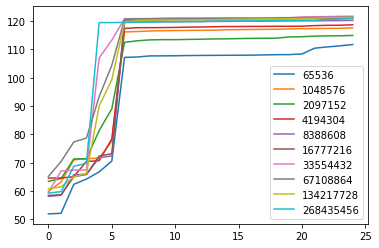

In [29]:
df.query("instance == 'r5a.large'").groupby("block_size")["mbps"].plot(legend=True, style="-", use_index=False);

Fastest instance type

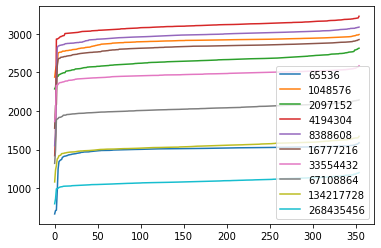

In [30]:
df.query("instance == 'c5.12xlarge'").groupby("block_size")["mbps"].plot(legend=True, style="-", use_index=False);

Fastest instance type that has different block size winner

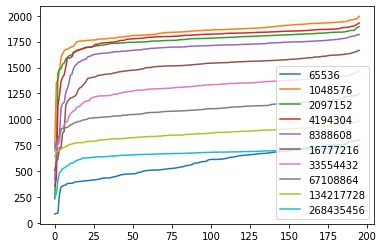

In [31]:
df.query("instance == 'r5a.16xlarge'").groupby("block_size")["mbps"].plot(legend=True, use_index=False);

## Median?

I think beginnings of runs are weird, but then they stabilize. This is not shown above.

Anywa, I think median is a fine metric for comparing the different block sizes given these data.

# Who's the overall winner?

Different instance types have slightly different results.

If we knew what the average user uses, we could choose the corresponding block size winner.

But we don't know what the average user uses.

Here's one idea:

For each positive real number $\alpha$, let $B(m,\alpha)$ be the set of block sizes whose median MB/s, on machine type $m$, are at most $\alpha$ percent slower than the fastest block size median on that instance type.

We will find the smallest $\alpha$ such that $\cap_{m} B(m, \alpha)$ is non empty. If it consists of a single block size - then that block size wins!

This captures the idea that we can settle for second best block size on a _single_ instance type, if it's only, say, 5% slower than the best block size for that instance type, as long as this block size is pretty good for _all_ instance types.

In [32]:
alpha=5
B = pd.concat([
    # Median per instance-block size
    df.groupby(["instance", "block_size"])["mbps"].median()
    # Is it at most alpha percent slower than the best?
    .gt(median_winner.set_index("instance")['mbps'] * (1 - alpha/100))
    # Percent of instance types
    .groupby("block_size").mean().mul(100).round()
    .rename(f"at most {alpha}% slower")
    for alpha in [9, 10, 12, 13]
], axis=1)
B

,at most 9% slower,at most 10% slower,at most 12% slower,at most 13% slower
block_size,,,,
65536,0.0,0.0,15.0,25.0
1048576,85.0,90.0,95.0,100.0
2097152,60.0,70.0,80.0,80.0
4194304,95.0,100.0,100.0,100.0
8388608,90.0,90.0,90.0,90.0
16777216,70.0,70.0,75.0,80.0
33554432,45.0,45.0,45.0,45.0
67108864,35.0,35.0,40.0,40.0
134217728,30.0,30.0,30.0,30.0


# 4 MB !

Choosing a block size of 4 MB for reading the Yellow NY Taxi data csv from 2020 is at worst 10% slower than the best block size, for each EC2 instance type that was run in this experiment, and no other block size that was tried satisfies this property.

The next block size to win the race is 1 MB, whose median on each instance type is at most 14% slower than the best median on that instance type.